In [2]:
import sympy as sp
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from tools import downsample_data

Now we will consider the kapitza pendulum where the base of the pendulum oscillates vertically:
\begin{equation}
y(t)=a\cos{\omega t}
\end{equation}

such that the position of the pendulum in polar coordinates are given as:
\begin{equation}
\vec{r}=\hat{x}\big(l\sin(\phi)+a\cos(\omega t)\big)-\hat{y}l\cos(\phi)
\end{equation}

In [3]:
# Define the symbols
t = sp.symbols('t')  # time
m, l, g, a, omega = sp.symbols('m l g a omega')   
phi = sp.symbols('phi', cls=sp.Function)  # angles as functions of time

# Define the angle functions and their derivatives
phi = phi(t)
phi_dot = sp.diff(phi, t)

x1, y1 = l*sp.sin(phi)+a*sp.cos(omega*t), -l*sp.cos(phi)

vx1, vy1 = sp.diff(x1,t), sp.diff(y1,t)

T = sp.Rational(1,2) * m * (vx1**2 + vy1**2)
U = m*g*l*(1-sp.cos(phi))

L = T-U

In [4]:
# Apply the Euler-Lagrange equation
EL1 = sp.diff(sp.diff(L, phi_dot), t) - sp.diff(L, phi)

# Optionally, simplify the equations
EL1_simplified = sp.Eq(sp.simplify(EL1),0)

In [5]:
# Defining the second order time deriv variables
phi_ddot= sp.diff(phi, t, t)
# Solving the system of EL equations for the second order time derivatives
# N.B. Solutions is a dict: variable -> equation
solutions = sp.solve([EL1_simplified], phi_ddot)

In [6]:
# Turning the second order equations into vectorized numpy functions that can efficiently evaluate numerical values
phi_ddot_lambdified = sp.lambdify([t, m, l, phi, phi_dot, a, omega, g], solutions[phi_ddot], 'numpy')

# Wrapping in outer function to make more recognizable 
def d2_phi_dt2(t: float,
               phi:float, 
               d_phi_dt: float, 
               length: float, 
               mass: float,
               amplitude: float,
               osc_frequency: float,
               g: float):
    return phi_ddot_lambdified(t, mass, length, phi, d_phi_dt, amplitude, osc_frequency, g)


In [7]:
# Define the ODE function
def kapitza_pendulum(t, y, l, m, a, w, g):
    phi, d_phi_dt = y
    d2_phi_dt2_value = d2_phi_dt2(t, phi, d_phi_dt, l, m, a, w, g)
    return [d_phi_dt, d2_phi_dt2_value]

# Initial conditions
phi_init = 0.9*np.pi
phi_dot_init = 0
initial_conditions = [phi_init, phi_dot_init]  

# Parameters
l = 1
m = 1
amplitude = 0.075
osc_frequency = 18
g = 9.82
params = (l, m, amplitude, osc_frequency, g)  

# Time span for the simulation
t_min, t_max = 0, 15
n_times = int(t_max*200)

time_span = np.linspace(start=t_min, stop=t_max, num=n_times)

# Solve the ODEs
solution = sc.integrate.solve_ivp(fun=kapitza_pendulum,
                        t_span=(t_min,t_max),
                        y0=initial_conditions,
                        method='Radau',
                        args=params,
                        t_eval=time_span)

print(solution.message)

The solver successfully reached the end of the integration interval.


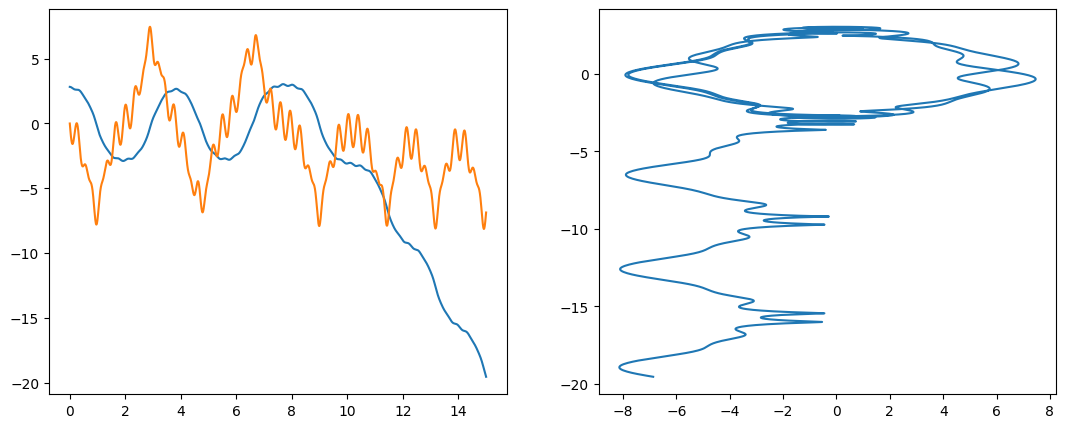

In [8]:
angles, angle_velocities = solution.y

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(solution.t, angles)
ax[0].plot(solution.t, angle_velocities)
ax[1].plot(angle_velocities, angles)

In [13]:
def get_energies(solver_result: sc.integrate._ivp.ivp.OdeResult,
                 mass: float,
                 length: float,
                 gravity: float,
                 amplitude: float,
                 osc_frequency: float):
    # Define the symbols
    t = sp.symbols('t')  # time
    m, l, g, a, omega = sp.symbols('m l g a omega')   
    phi = sp.symbols('phi', cls=sp.Function)  # angles as functions of time
    
    # Define the angle functions and their derivatives
    phi = phi(t)
    phi_dot = sp.diff(phi, t)
    
    x1, y1 = l*sp.sin(phi), -(l*sp.cos(phi)+a*sp.cos(omega*t))
    
    vx1, vy1 = sp.diff(x1,t), sp.diff(y1,t)
    
    T = sp.Rational(1,2) * m * (vx1**2 + vy1**2)
    U = m*g*(l*(1-sp.cos(phi))+a*sp.cos(omega*t))

    # Lambdify the energy expressions
    T_func = sp.lambdify([t,m,l,g,a,omega,phi,phi_dot], T, 'numpy')
    U_func = sp.lambdify([t,m,l,g,a,omega,phi,phi_dot], U, 'numpy')

    # Extract the solver's results
    phi_values, phi_dot_values = solver_result.y
    times = solver_result.t

    # Calculate energies
    kinetic_energies = T_func(times, mass, length, gravity, amplitude, osc_frequency, phi_values, phi_dot_values)
    
    potential_energies = U_func(times, mass, length, gravity, amplitude, osc_frequency, phi_values, phi_dot_values)

    return kinetic_energies, potential_energies


def get_cartesian_coordinates(solver_result: sc.integrate._ivp.ivp.OdeResult,
                              length: float, 
                              amplitude: float,
                              osc_frequency: float):
    def angle_to_xy(angle: float, 
                    distance: float, 
                    amplitude: float,
                    osc_frequency: float,
                    time: float):
        return np.array([distance * np.sin(angle)+amplitude*np.cos(osc_frequency*time), 
                         -distance * np.cos(angle)])

        # Extract the solver's results

    _phi_, _,  = solver_result.y

    times = solver_result.t
    pendulum = np.array([angle_to_xy(angle=angle, distance=length, amplitude=amplitude, osc_frequency=osc_frequency, time=t).tolist() for angle, t in zip(_phi_,times)])
    base = np.array([[amplitude*np.cos(osc_frequency*t),0] for t in times])

    return pendulum, base, times

In [14]:
kinetic_energies, potential_energies = get_energies(solver_result=solution,
                                                    mass=m,
                                                    length=l,
                                                    amplitude=amplitude,
                                                    osc_frequency=osc_frequency,
                                                    gravity=g)

In [15]:
_pendulum_, _base_, _times_ = get_cartesian_coordinates(solver_result=solution,
                                                        length=l,
                                                        amplitude=amplitude,
                                                        osc_frequency=osc_frequency)
                                                        
"""sample_rate = n_times//1000
pendulum_vals, base_vals, time_vals = _pendulum_[::sample_rate], _base_[::sample_rate], _times_[::sample_rate]"""
pendulum_vals, base_vals, time_vals = _pendulum_, _base_, _times_

 22%|██▏       | 668/3000 [00:19<01:35, 24.52it/s]

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1500x1500', '-pix_fmt', 'rgba', '-r', '500', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'artist=Sebastian Yde', '-y', 'horizontal_kapitza_pendulum_animation.mp4']' returned non-zero exit status 255.

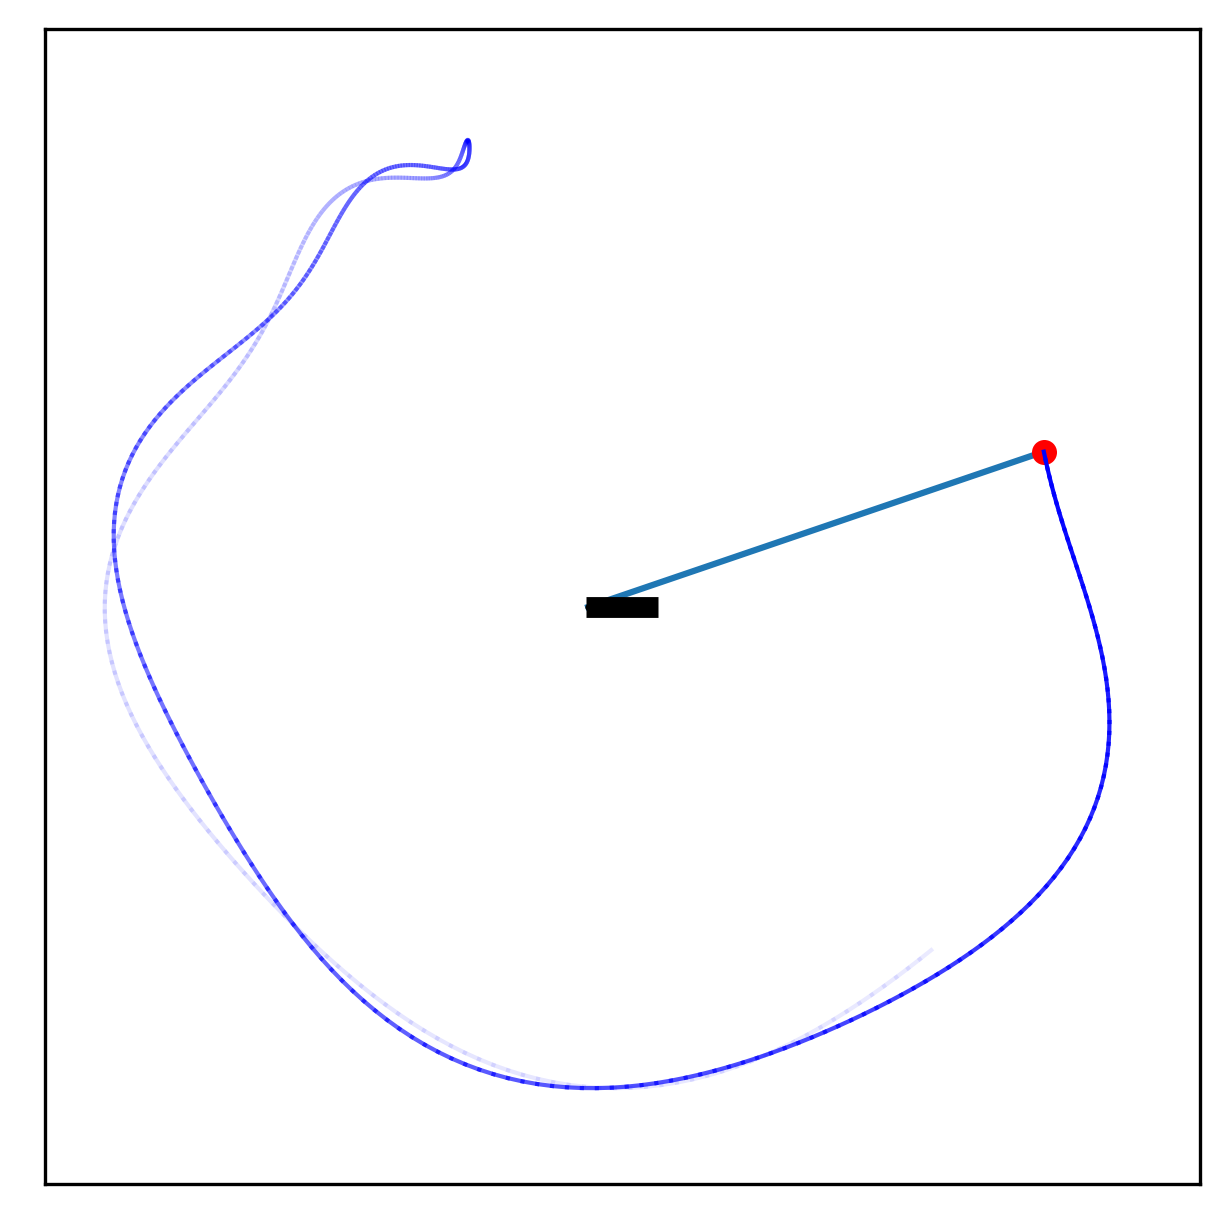

In [17]:
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation


# Create a tqdm progress bar
pbar = tqdm(total=len(time_vals))


resolution = 300
fig, ax = plt.subplots(figsize=(5, 5), dpi=resolution)

# Initial plot elements
line, = ax.plot([], [], lw=1.5)  # Line for the upper arm
point, = ax.plot([], [], 'ro', ms=5)  # Point for the upper pendulum
base, = ax.plot([], [], 'ko', ms=0.5)

# Store the trace data as a list of line segments
trace_segments = []

# Parameters for the trace
trace_length = 500  # Adjust as needed
fade_factor = 0.995  # Adjust for different fading speeds
fade_trace = True  # Set to False to disable fading

# Initialization function
def init():
    line.set_data([], [])
    point.set_data([], [])
    base.set_data([], [])
    return line, point, base

# Animation update function
def update(idx):
    # base
    base.set_data(base_vals[idx, 0], base_vals[idx, 1])
    
    # arm
    line.set_data([base_vals[idx, 0], pendulum_vals[idx, 0]], [base_vals[idx, 1], pendulum_vals[idx, 1]])
    point.set_data(pendulum_vals[idx, 0], pendulum_vals[idx, 1])

    # Update trace
    if idx > 0:
        new_segment, = ax.plot([pendulum_vals[idx-1, 0], pendulum_vals[idx, 0]],
                               [pendulum_vals[idx-1, 1], pendulum_vals[idx, 1]], 
                               color='blue', lw=1, alpha=1)
        trace_segments.append(new_segment)

        # Fade older segments if fade_trace is True
        if fade_trace:
            for segment in trace_segments[:-1]:  # Exclude the newest segment
                alpha = segment.get_alpha() * fade_factor
                segment.set_alpha(alpha)

        # Remove the oldest segment if trace is too long
        if len(trace_segments) > trace_length:
            old_segment = trace_segments.pop(0)
            old_segment.remove()
            
    pbar.update(1)

    return [line, point, base] + trace_segments

# Setting additional things
ax.set_xlim(-1.2*l, 1.2*l)
ax.set_ylim(-1.2*l, 1.2*l)
ax.set_aspect('equal')
ax.hlines(0, -amplitude, amplitude, lw=5, color='k')

# Remove axis ticks and labels
ax.set_xticks([]), ax.set_yticks([])
ax.set_xlabel(''), ax.set_ylabel('')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(time_vals), init_func=init, blit=True, interval=1)

# Set up the writer
Writer = animation.writers['ffmpeg']
writer = Writer(fps=500, metadata=dict(artist='Sebastian Yde'))

# Save the animation
ani.save('horizontal_kapitza_pendulum_animation.mp4', writer=writer)

plt.close(fig)